# Time-Series Forecasting Methods using Darts Library Baseline Models

https://unit8co.github.io/darts/examples.html

# Data

As our dataset we will use the "Carbon-monitor-..." which contains the values of contribution for each sector compared to the total amount of all sectors from 2019-01-01 until 2023-05-31

In [64]:
import pandas as pd
import numpy as np

df = pd.read_csv('DataSets /WORLD-OWID-Features-Yearly')
#df = df.drop(['land_use_change_co2', 'other_industry_co2'], axis=1)
df.head()

,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
0,1880-01-01,0.0,853.705,838.340,256.309556,1814.698707,3100.721,15.364,82.069576
1,1881-01-01,0.0,882.405,865.162,256.309556,1814.698707,3096.935,17.242,82.069576
2,1882-01-01,0.0,931.922,912.817,256.309556,0.165000,3159.833,18.939,82.069576
3,1883-01-01,0.0,991.032,974.149,256.309556,0.381000,3220.534,16.502,82.069576
4,1884-01-01,0.0,1002.174,982.679,256.309556,1.172000,3240.197,18.323,82.069576


Since we are using forecasting models, we will first replace our index with our 'year'

In [24]:
# This will be done later, after formatting our 'year' column to timeformat

#df.set_index('year', inplace=True) # To create this as a new dataframe -> Index=False

#We will set our 'year' column as index using the darts 'TimeSeries' function

# Installation Darts Library

**Darts** Guide Github: https://unit8co.github.io/darts/quickstart/00-quickstart.html

In [ ]:
#!pip install darts
#!pip install optuna

If while installing 'darts' you have trouble (with lightgbm), here is the documentation: https://lightgbm.readthedocs.io/en/latest/Quick-Start.html

In [4]:
import torch
from darts import TimeSeries
from darts.models import *
from darts.metrics import *
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import GaussianLikelihood, LogNormalLikelihood, PoissonLikelihood, NegativeBinomialLikelihood, QuantileRegression
import logging

logging.disable(logging.CRITICAL)

In [5]:
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import plot_optimization_history, plot_contour, plot_param_importances
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

# Preprocessing Data + Turning into TimeSeries

In [25]:
df['year'] = pd.to_datetime(df['year'], format="%Y-%m-%d")   #,format="%Y-%m-%d")
df.index.freq = 'A'

#year_column = df['year']
# Set 'date' column as the index
df.set_index('year')

test_dates = df['year'][130:]
test_dates
#df = df.resample('W').sum()  # Grouping and summarizing the data on a weekly base

130   2010-01-01
131   2011-01-01
132   2012-01-01
133   2013-01-01
134   2014-01-01
135   2015-01-01
136   2016-01-01
137   2017-01-01
138   2018-01-01
139   2019-01-01
140   2020-01-01
141   2021-01-01
Name: year, dtype: datetime64[ns]

In [43]:
co2_df = df['co2'].loc['1880':]
log_co2_df = np.log(co2_df)

co2_data = log_co2_df
co2_train_size = int(len(co2_data)-10)

co2_train, co2_test = co2_data[0:co2_train_size], co2_data[co2_train_size:len(co2_data)]

co2_train = TimeSeries.from_dataframe(pd.DataFrame({'CO2': co2_train}),                                      
                                      value_cols='CO2')

co2_test = TimeSeries.from_dataframe(pd.DataFrame({'CO2': co2_test}),
                                     
                                      value_cols='CO2')

In [54]:
co2_df = df['co2'].loc['1880':]
log_co2_df = np.log(co2_df)    ## No np.log applied

val_size = 11  # Last 21 to last 10 rows
test_size = 10  # Last 10 rows

# Calculate the size of the training set
train_size = len(log_co2_df) - (val_size + test_size)

# Split the data into training, validation, and test sets
co2_train = log_co2_df[:train_size]
co2_val = log_co2_df[train_size:train_size + val_size]
co2_test = log_co2_df[train_size + val_size:]

# Convert to Darts TimeSeries objects
co2_train = TimeSeries.from_dataframe(pd.DataFrame({'CO2': co2_train}),
                                     value_cols='CO2')

co2_val = TimeSeries.from_dataframe(pd.DataFrame({'CO2': co2_val}),
                                   value_cols='CO2')

co2_test = TimeSeries.from_dataframe(pd.DataFrame({'CO2': co2_test}),
                                    value_cols='CO2')


In [60]:
co2_val

<TimeSeries (DataArray) (time: 11, component: 1, sample: 1)>
array([[[10.15300227]],

       [[10.17660293]],

       [[10.22743873]],

       [[10.26244422]],

       [[10.29602283]],

       [[10.32853033]],

       [[10.35795833]],

       [[10.37616997]],

       [[10.35977349]],

       [[10.41524318]],

       [[10.44833807]]])
Coordinates:
  * time       (time) int64 121 122 123 124 125 126 127 128 129 130 131
  * component  (component) object 'CO2'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# Visualizing

There are a lot of visualitzation techniques al clearly explained in the documentation: https://unit8co.github.io/darts/quickstart/00-quickstart.html

<function matplotlib.pyplot.show(close=None, block=None)>

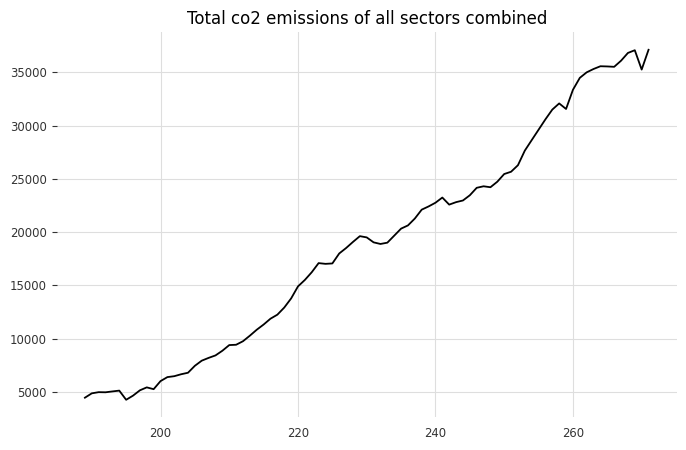

In [12]:
import matplotlib.pyplot as plt

co2_df.plot(figsize=(8,5))
plt.title('Total co2 emissions of all sectors combined')

plt.show

In [13]:
import matplotlib as mpl
from statsmodels.tsa.seasonal import seasonal_decompose

# We can use the seasonal_decompose to get a better view at the trend and seasonality
mpl.rcParams['figure.figsize'] = (8,6)

result = seasonal_decompose(df['co2'])
result.plot()

plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

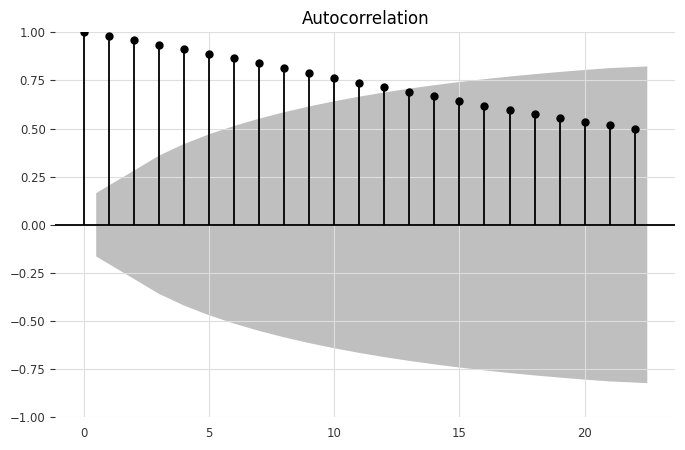

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8,5))

plot_acf(df['co2'], ax = ax)

plt.show()

In [ ]:
#series = TimeSeries.from_dataframe(df, 'year', 'co2')


# Splits the series into two parts based on a given split ratio
#series1, series2 = series.split_before(0.75)
#series1.plot()
#series2.plot()

In [ ]:
#series_noise = TimeSeries.from_times_and_values(
    #series.time_index, np.random.randn(len(series))
#)
#(series / 2 + 20 * series_noise - 10).plot()

In [ ]:
#series1, series2 = series[:-36], series[-36:]
#series1.plot()
#series2.plot()

# Normalizing our data (only when not using np.log)

In [26]:
#transformer = Scaler()
#train_transformed = transformer.fit_transform(train)
#val_transformed = transformer.transform(val)
#series_transformed = transformer.transform(series)

# Backtest and Metrics Helper Functions

In [55]:
from darts.metrics import mae, rmse, mape, smape, r2_score
import matplotlib.pyplot as plt

# actual values of the time series and the forecasted values. Takes in the model chosen

def plot_backtest(series, forecast, model_name):
    idx = -40   # By setting our index to -40 we wille trying to forecast our latest 40 years.
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.title(model_name)
    plt.show()

# calculates various evaluation metrics for the forecasted values compared to the actual values

def print_metrics(series, forecast, model_name):
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    mape_ = mape(series, forecast)
    smape_ = smape(series, forecast)
    r2_score_ = r2_score(series, forecast)

    dict_ = {
        'MAE': mae_,
        'RMSE': rmse_,
        'MAPE': mape_,
        'SMAPE': smape_,
        'R2': r2_score_
    }

    df = pd.DataFrame(dict_, index=[model_name])

    return df.round(decimals=2)

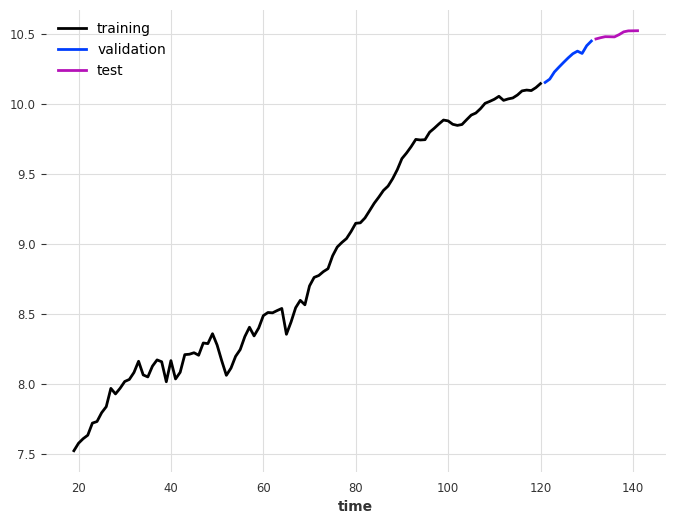

In [56]:
#train, val = series.split_before(pd.Timestamp("1980-01-01"))   # Start prediction from this date
co2_train.plot(label="training")
co2_val.plot(label="validation")
co2_test.plot(label="test")

# Creating a Naive Forecasting BaseModel

**Based on the series method**

100%|██████████| 21/21 [00:00<00:00, 56.35it/s]


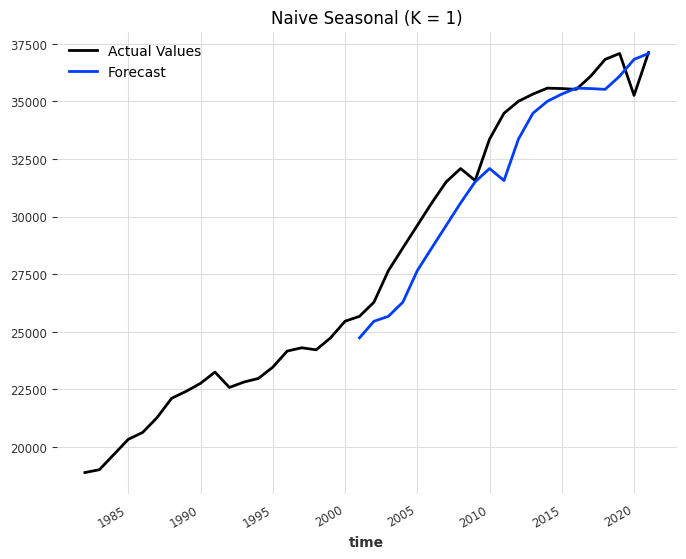

100%|██████████| 21/21 [00:00<00:00, 27.17it/s]


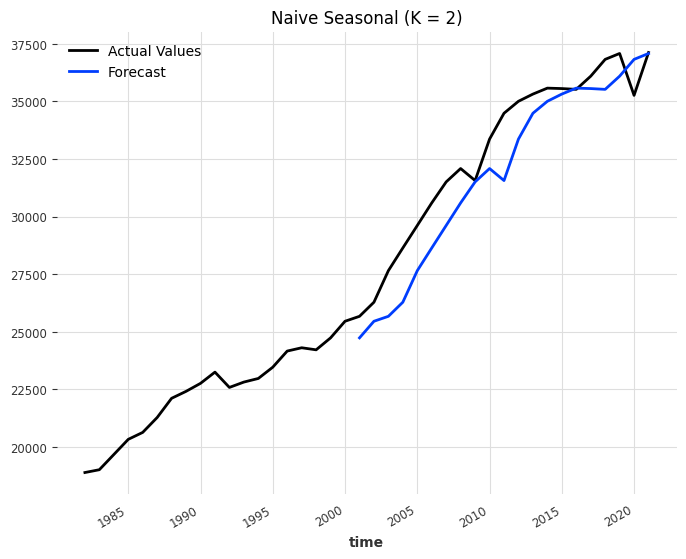

100%|██████████| 21/21 [00:00<00:00, 75.39it/s]


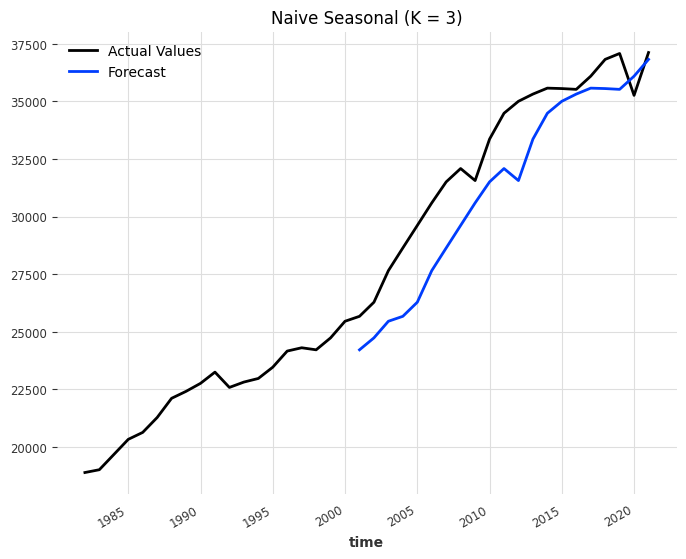

100%|██████████| 21/21 [00:00<00:00, 73.03it/s]


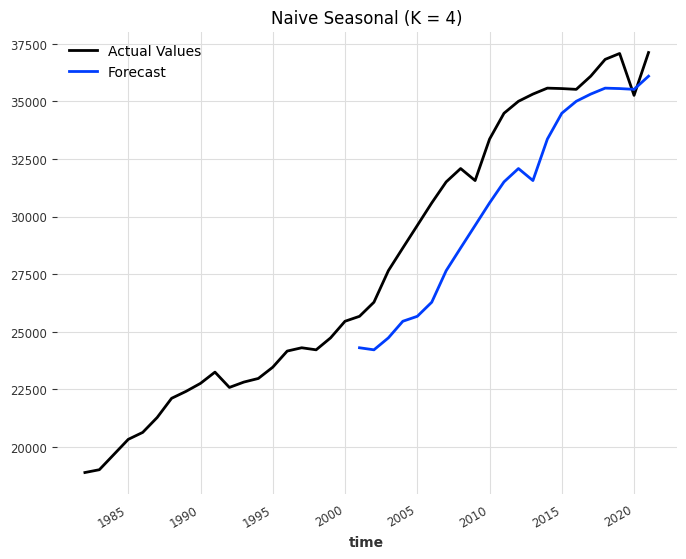

100%|██████████| 21/21 [00:00<00:00, 133.37it/s]


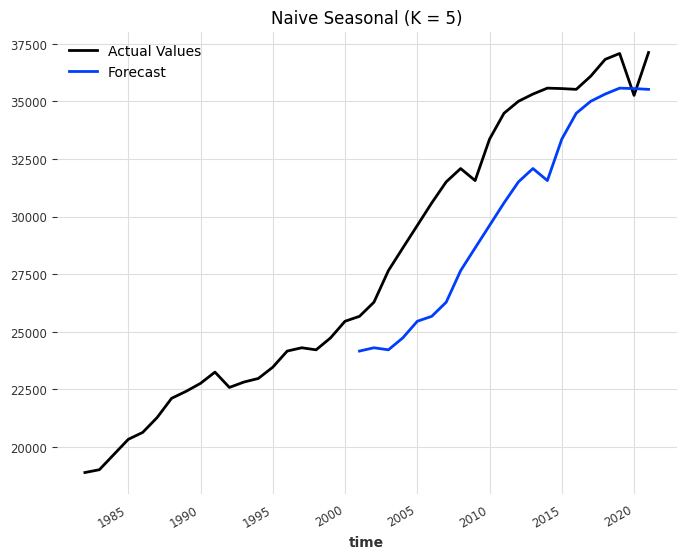

100%|██████████| 21/21 [00:00<00:00, 123.89it/s]


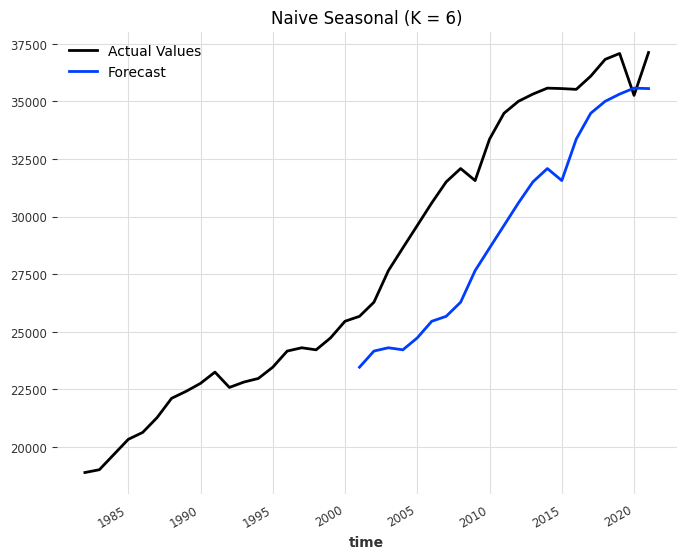

100%|██████████| 21/21 [00:00<00:00, 134.30it/s]


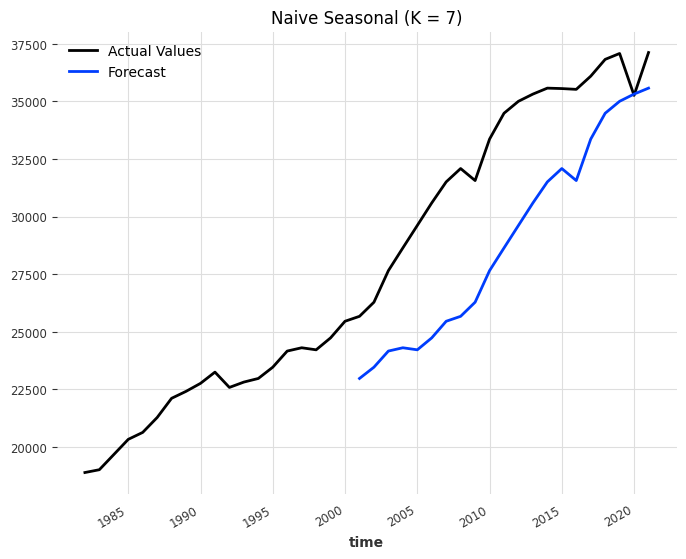

100%|██████████| 21/21 [00:00<00:00, 139.29it/s]


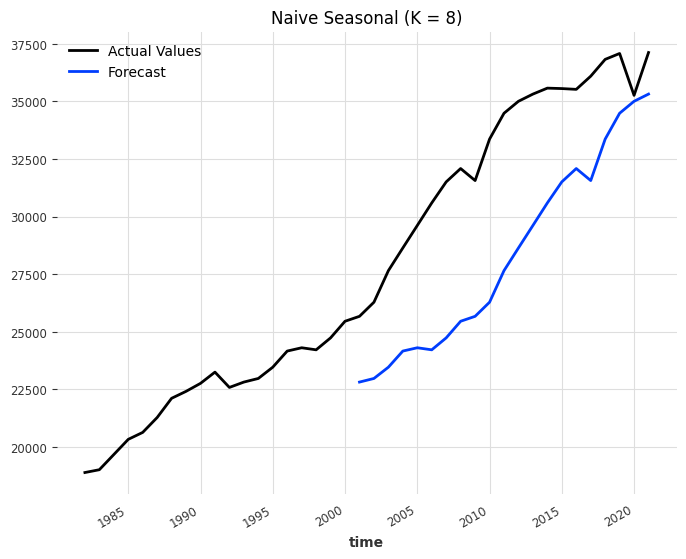

100%|██████████| 21/21 [00:00<00:00, 123.16it/s]


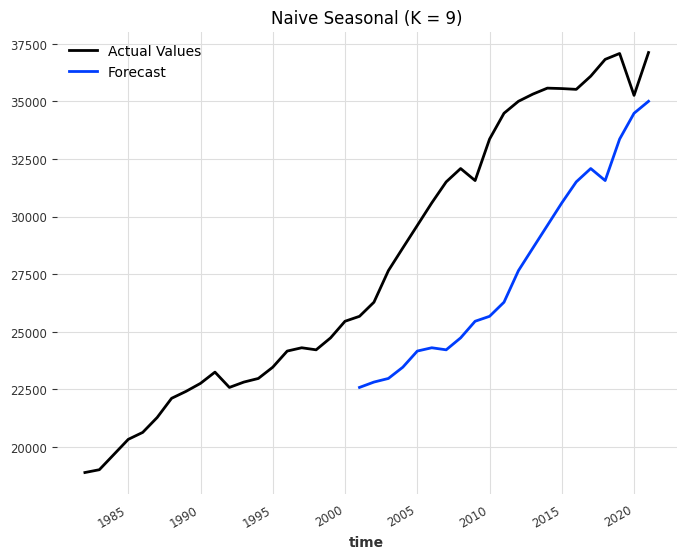

100%|██████████| 21/21 [00:00<00:00, 119.00it/s]


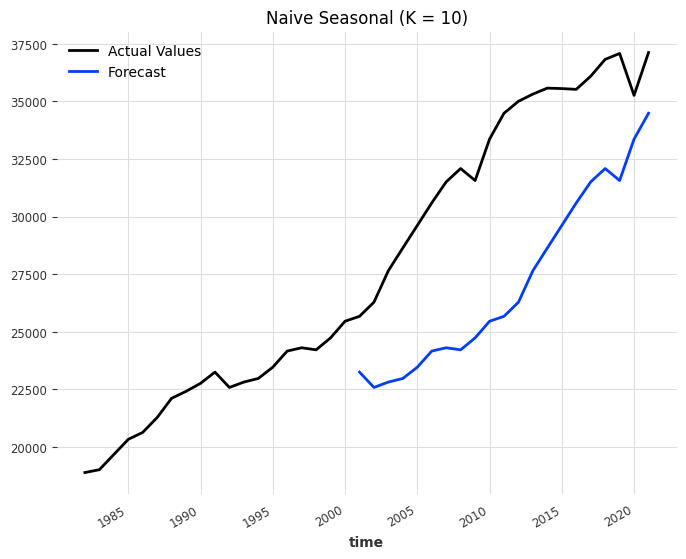

100%|██████████| 21/21 [00:00<00:00, 118.82it/s]


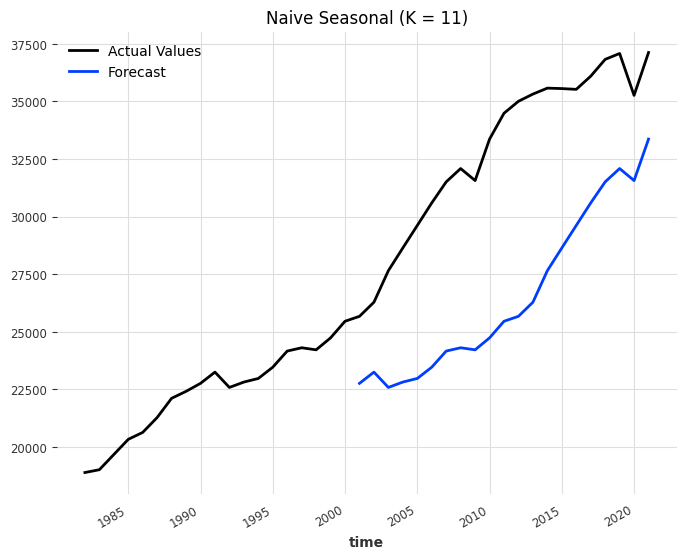

100%|██████████| 21/21 [00:00<00:00, 133.65it/s]


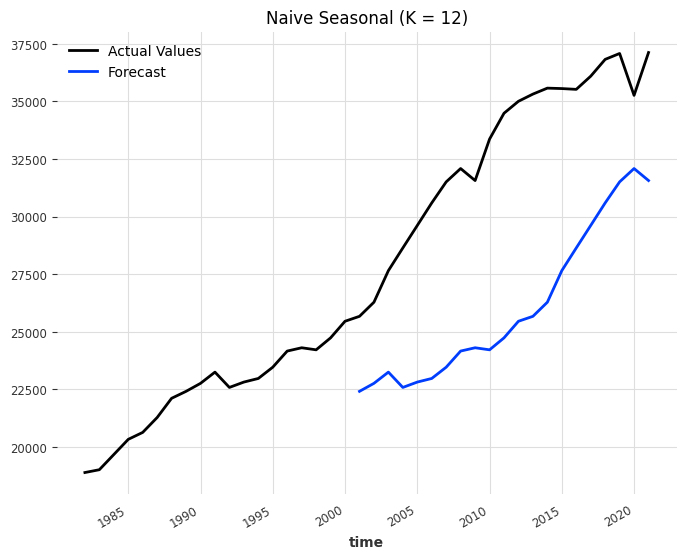

100%|██████████| 21/21 [00:00<00:00, 109.60it/s]


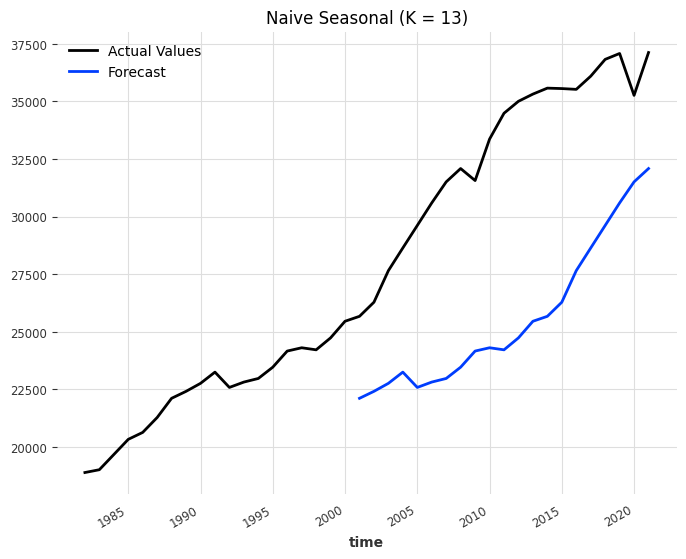

100%|██████████| 21/21 [00:00<00:00, 126.99it/s]


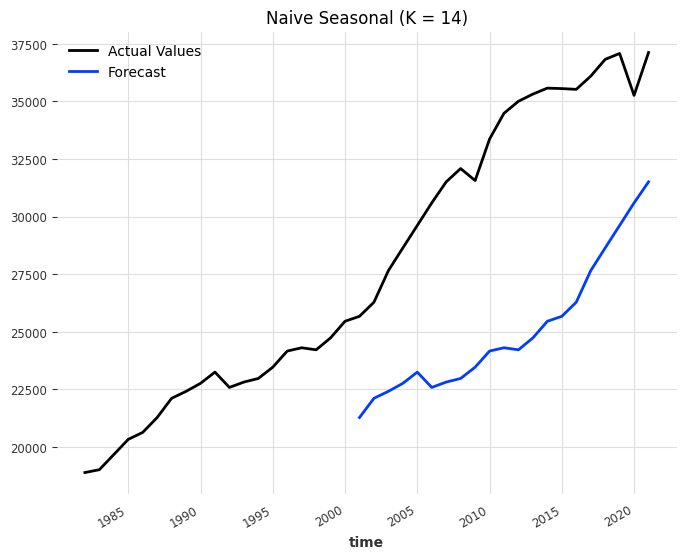

100%|██████████| 21/21 [00:00<00:00, 59.70it/s]


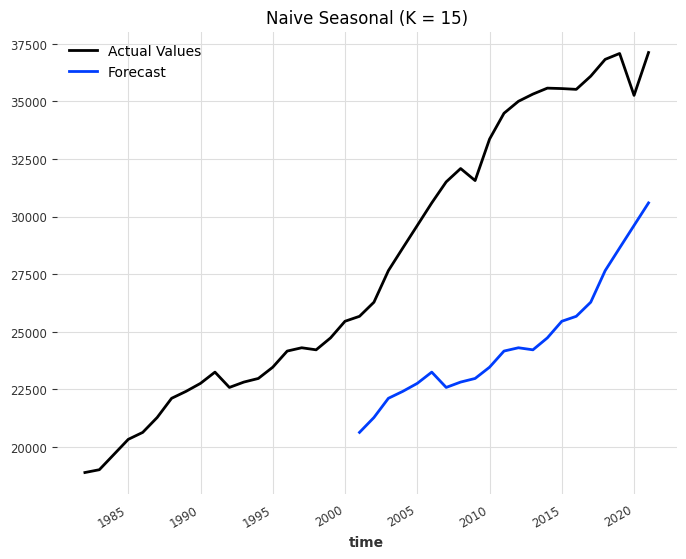

100%|██████████| 21/21 [00:00<00:00, 77.71it/s]


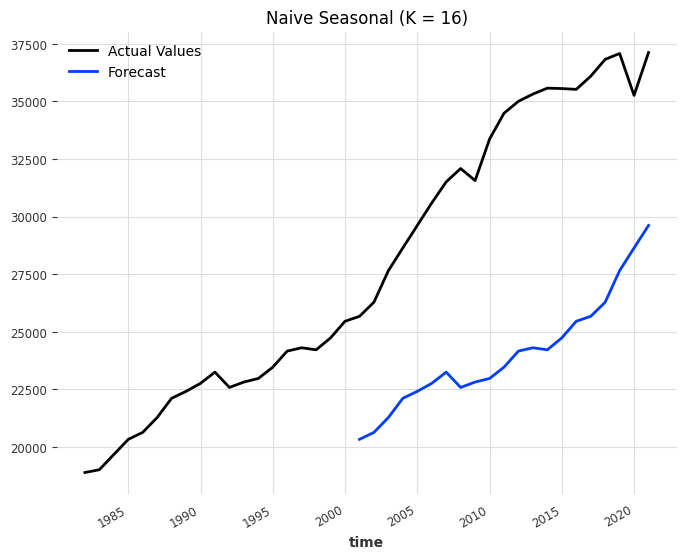

100%|██████████| 21/21 [00:00<00:00, 70.03it/s]


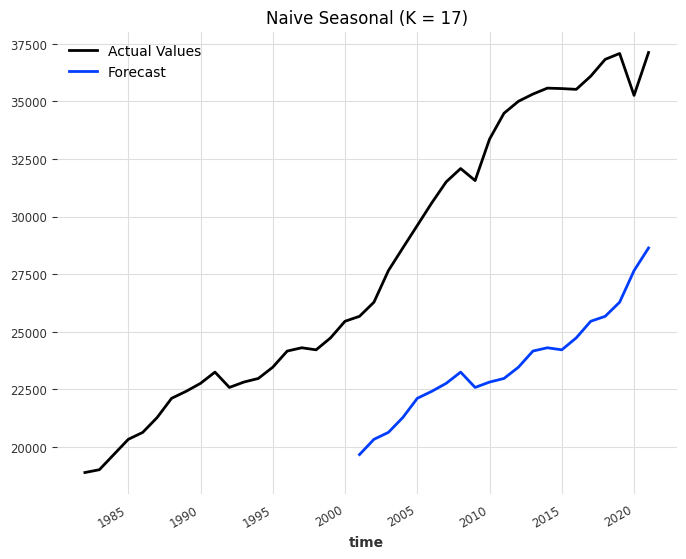

100%|██████████| 21/21 [00:00<00:00, 67.17it/s]


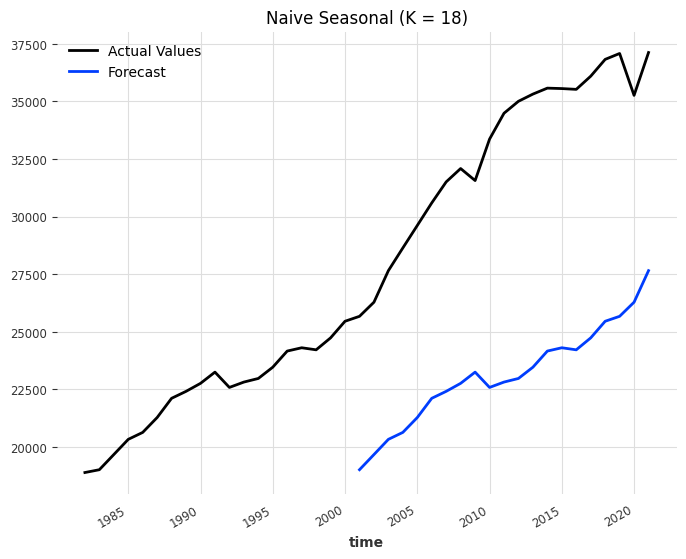

100%|██████████| 21/21 [00:00<00:00, 70.16it/s]


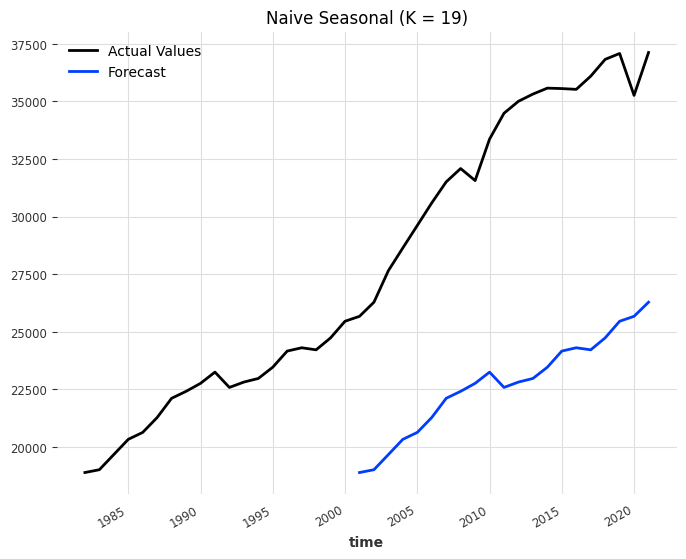

                                  MAE          RMSE   MAPE  SMAPE    R2
Naive Seasonal (K = 1)    1211.119995   1445.689941   3.81   3.91  0.83
Naive Seasonal (K = 2)    1211.119995   1445.689941   3.81   3.91  0.83
Naive Seasonal (K = 3)    1749.359985   2008.569946   5.52   5.74  0.68
Naive Seasonal (K = 4)    2291.209961   2587.870117   7.20   7.56  0.47
Naive Seasonal (K = 5)    2862.929932   3182.250000   8.94   9.47  0.19
Naive Seasonal (K = 6)    3439.280029   3766.939941  10.70  11.45 -0.13
Naive Seasonal (K = 7)    4014.159912   4351.870117  12.45  13.45 -0.51
Naive Seasonal (K = 8)    4616.750000   4956.919922  14.25  15.53 -0.96
Naive Seasonal (K = 9)    5223.379883   5557.479980  16.04  17.65 -1.47
Naive Seasonal (K = 10)   5783.439941   6104.609863  17.65  19.58 -1.98
Naive Seasonal (K = 11)   6341.990234   6629.740234  19.27  21.53 -2.51
Naive Seasonal (K = 12)   6863.609863   7159.720215  20.78  23.40 -3.09
Naive Seasonal (K = 13)   7313.910156   7618.620117  22.10  25.0

In [ ]:
from darts.models import NaiveSeasonal

naive_forecastings_series = pd.DataFrame()

for k in range(1, 20):

  model = NaiveSeasonal(K = k)
  model_name = f'Naive Seasonal (K = {k})'
  model.fit(series)


  forecast = model.historical_forecasts(series, start=start, forecast_horizon=2, verbose=True)
  plot_backtest(series, forecast, model_name)
  df_naive_series = print_metrics(series, forecast, model_name)
  naive_forecastings_series = pd.concat([naive_forecastings_series, df_naive_series])

plt.show()
print(naive_forecastings_series)

**Based on the train/test set method**

In [63]:
naive_forecastings = pd.DataFrame()

# Loop through values of K
for k in range(1, 30):
    # Create and fit the model with the value of K
    model = NaiveSeasonal(K=k)
    model_name = f'Naive Seasonal (K = {k})'
    model.fit(co2_train)

    # Make predictions on the validation set
    forecast_val = model.predict(len(co2_val))
    forecast_test = model.predict(len(co2_test))

    # Access the actual values from the TimeSeries objects
    forecast_val_values = forecast_val.values()
    co2_val_values = co2_val.values()
    forecast_test_values = forecast_test.values()
    co2_test_values = co2_test.values()

   # Calculate the metrics for validation set
    val_metrics = print_metrics(co2_val, forecast_val, model_name)

# Calculate the metrics for test set
    test_metrics = print_metrics(co2_test, forecast_test, model_name)


    # Print metrics for validation and test sets
    print(f"{model_name} - Validation Metrics:")
    print(val_metrics)
    print(f"{model_name} - Test Metrics:")
    print(test_metrics)
    print()

    # Append the metrics to the naive_forecastings dataframe
    df_naive = pd.DataFrame({
        'Model': [model_name],
        'MAPE Validation': [val_metrics['MAPE']],
        'MAPE Test': [test_metrics['MAPE']]
    })
    naive_forecastings = pd.concat([naive_forecastings, df_naive])

    # Optionally plot the forecast for each value of K
    # plot_backtest(co2_val_values, forecast_val_values, model_name)  # Uncomment this line if needed

# Print the metrics for all values of K
print(val_metrics)


/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value enco

Naive Seasonal (K = 1) - Validation Metrics:
                         MAE  RMSE  MAPE  SMAPE    R2
Naive Seasonal (K = 1)  0.16  0.19  1.59   1.61 -3.26
Naive Seasonal (K = 1) - Test Metrics:
                        MAE  RMSE  MAPE  SMAPE  R2
Naive Seasonal (K = 1)  NaN   NaN   NaN    NaN NaN

Naive Seasonal (K = 2) - Validation Metrics:
                         MAE  RMSE  MAPE  SMAPE    R2
Naive Seasonal (K = 2)  0.18   0.2  1.74   1.76 -3.93
Naive Seasonal (K = 2) - Test Metrics:
                        MAE  RMSE  MAPE  SMAPE  R2
Naive Seasonal (K = 2)  NaN   NaN   NaN    NaN NaN

Naive Seasonal (K = 3) - Validation Metrics:
                         MAE  RMSE  MAPE  SMAPE    R2
Naive Seasonal (K = 3)  0.19  0.21  1.87   1.89 -4.52
Naive Seasonal (K = 3) - Test Metrics:
                        MAE  RMSE  MAPE  SMAPE  R2
Naive Seasonal (K = 3)  NaN   NaN   NaN    NaN NaN

Naive Seasonal (K = 4) - Validation Metrics:
                        MAE  RMSE  MAPE  SMAPE    R2
Naive Seasonal (K

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value enco

Naive Seasonal (K = 13) - Validation Metrics:
                          MAE  RMSE  MAPE  SMAPE    R2
Naive Seasonal (K = 13)  0.26  0.27   2.5   2.54 -7.57
Naive Seasonal (K = 13) - Test Metrics:
                         MAE  RMSE  MAPE  SMAPE  R2
Naive Seasonal (K = 13)  NaN   NaN   NaN    NaN NaN

Naive Seasonal (K = 14) - Validation Metrics:
                          MAE  RMSE  MAPE  SMAPE    R2
Naive Seasonal (K = 14)  0.27  0.28  2.62   2.65 -8.23
Naive Seasonal (K = 14) - Test Metrics:
                         MAE  RMSE  MAPE  SMAPE  R2
Naive Seasonal (K = 14)  NaN   NaN   NaN    NaN NaN

Naive Seasonal (K = 15) - Validation Metrics:
                          MAE  RMSE  MAPE  SMAPE    R2
Naive Seasonal (K = 15)  0.29  0.29  2.76    2.8 -9.13
Naive Seasonal (K = 15) - Test Metrics:
                         MAE  RMSE  MAPE  SMAPE  R2
Naive Seasonal (K = 15)  NaN   NaN   NaN    NaN NaN

Naive Seasonal (K = 16) - Validation Metrics:
                         MAE  RMSE  MAPE  SMAPE    

/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wout_vp/venv-metal/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value enco

In [48]:
forecast_numpy = forecast.pd_dataframe().to_numpy()
forecast_values_val = np.exp(forecast_numpy)

co2_test_numpy = co2_val.pd_dataframe().to_numpy()
co2_test_values = np.exp(co2_test_numpy)

/var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_59875/3342992685.py:5: RuntimeWarning: overflow encountered in exp
  co2_test_values = np.exp(co2_test_numpy)


In [53]:
forecast_series = pd.Series(forecast_values_val.flatten())
co2_test_series = pd.Series(co2_test_values.flatten())

result_df = pd.DataFrame({'forecast': forecast_series, 'co2 Test': co2_test_series})

result_df.index = df.index[-11:]

print(result_df)

      forecast  co2 Test
131  19006.539       inf
132  19664.754       inf
133  20325.486       inf
134  20627.359       inf
135  21273.904       inf
136  22107.795       inf
137  22410.402       inf
138  22757.480       inf
139  23244.807       inf
140  22580.023       inf
141  22812.900       inf


# Exponential Smoothening BaseLine Model

This model can only be used with 1 feature, not with multiple features.

**Series Method**

100%|██████████| 11/11 [00:01<00:00,  6.61it/s]


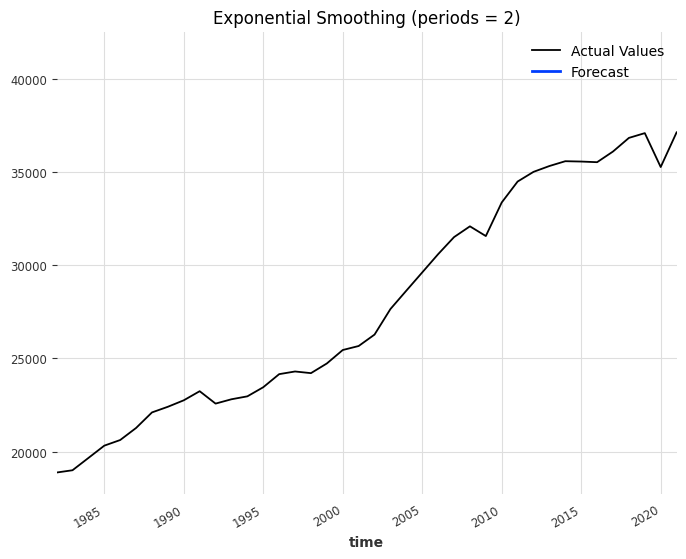

100%|██████████| 11/11 [00:01<00:00,  8.75it/s]


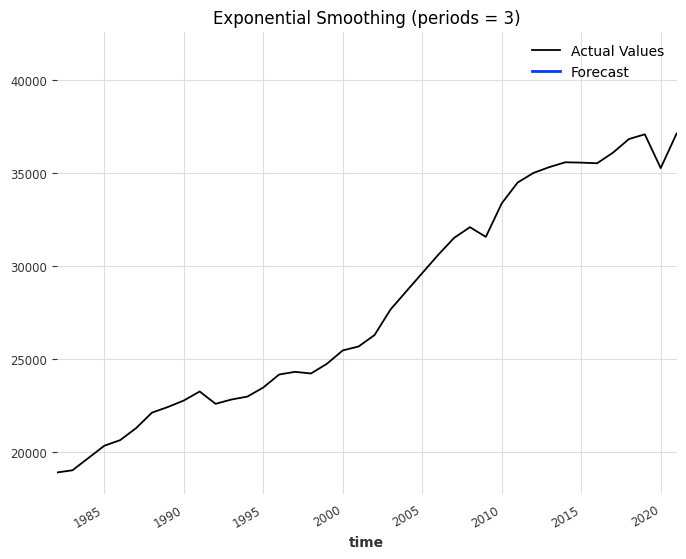

100%|██████████| 11/11 [00:01<00:00,  8.82it/s]


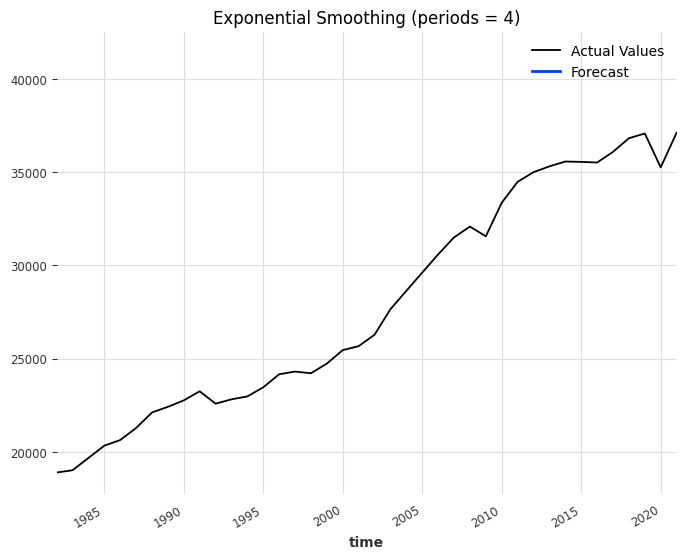

100%|██████████| 11/11 [00:01<00:00,  6.41it/s]


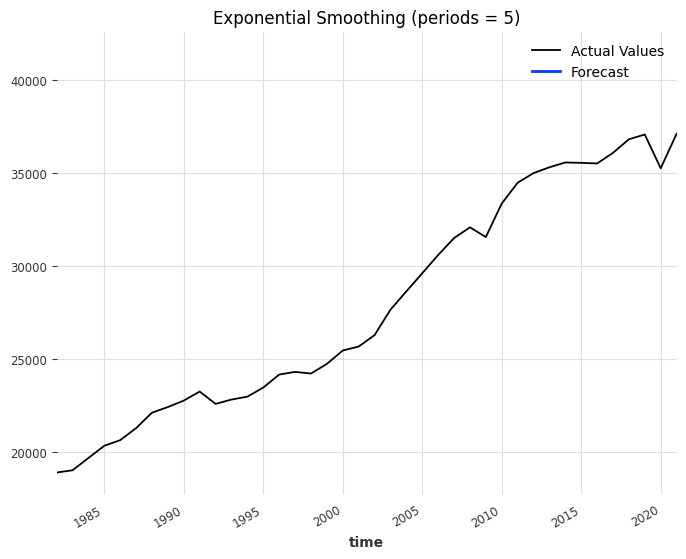

100%|██████████| 11/11 [00:01<00:00,  5.85it/s]


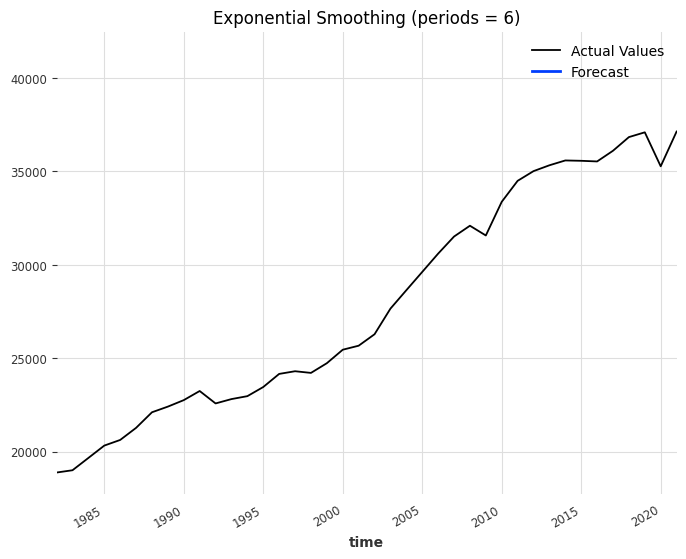

100%|██████████| 11/11 [00:01<00:00,  7.57it/s]


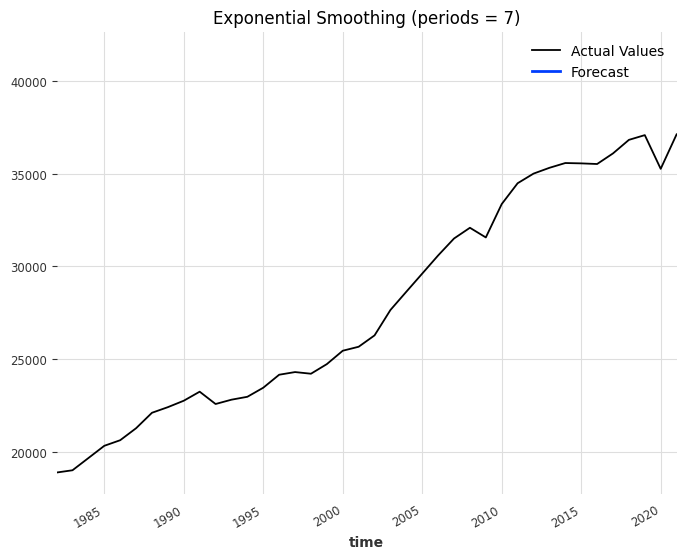

100%|██████████| 11/11 [00:01<00:00,  8.47it/s]


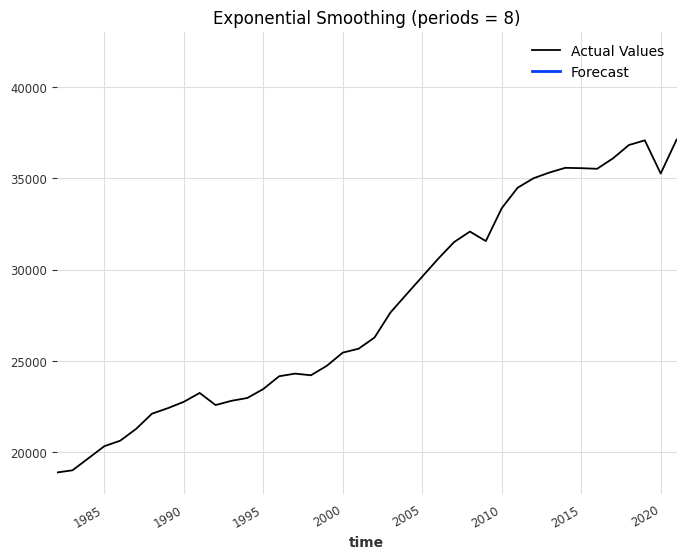

100%|██████████| 11/11 [00:02<00:00,  5.13it/s]


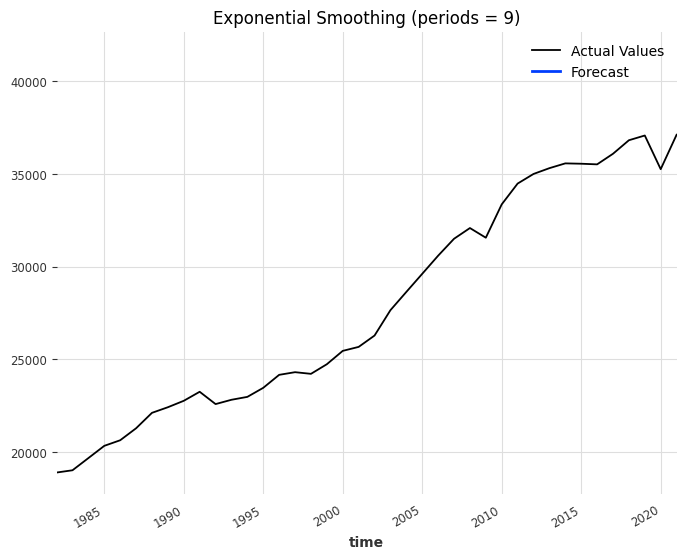

100%|██████████| 11/11 [00:02<00:00,  4.71it/s]


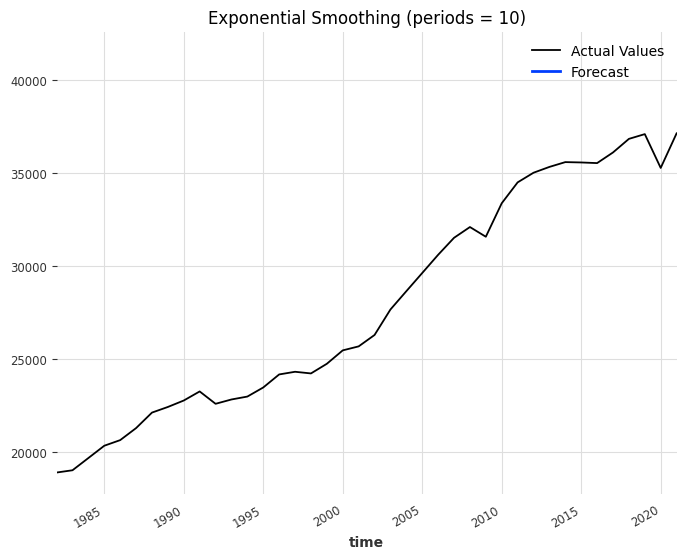

100%|██████████| 11/11 [00:03<00:00,  3.16it/s]


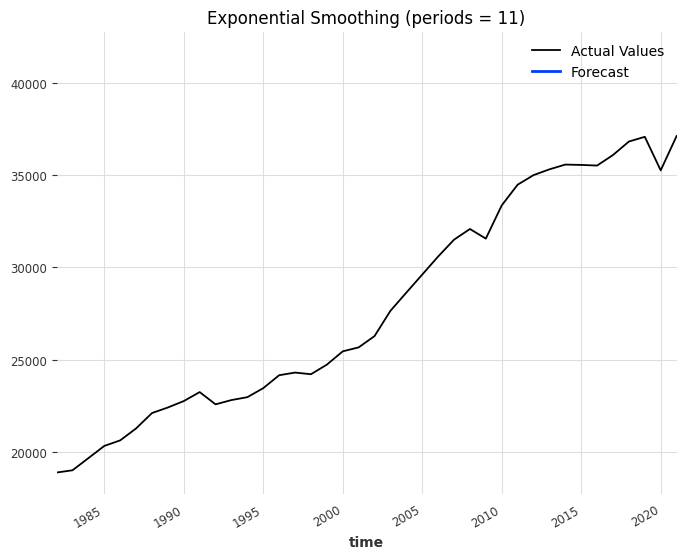

100%|██████████| 11/11 [00:01<00:00,  6.28it/s]


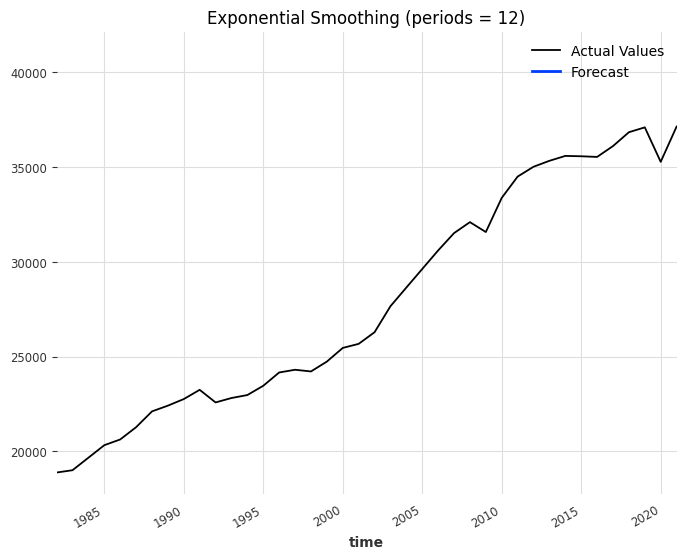

100%|██████████| 11/11 [00:02<00:00,  4.33it/s]


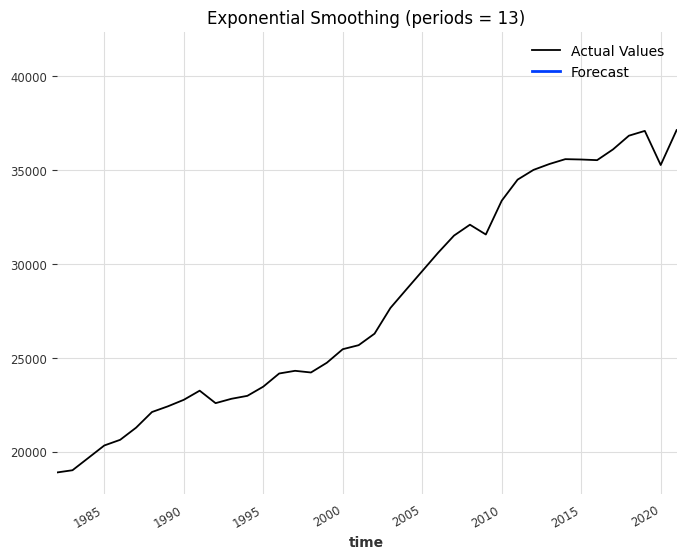

100%|██████████| 11/11 [00:04<00:00,  2.72it/s]


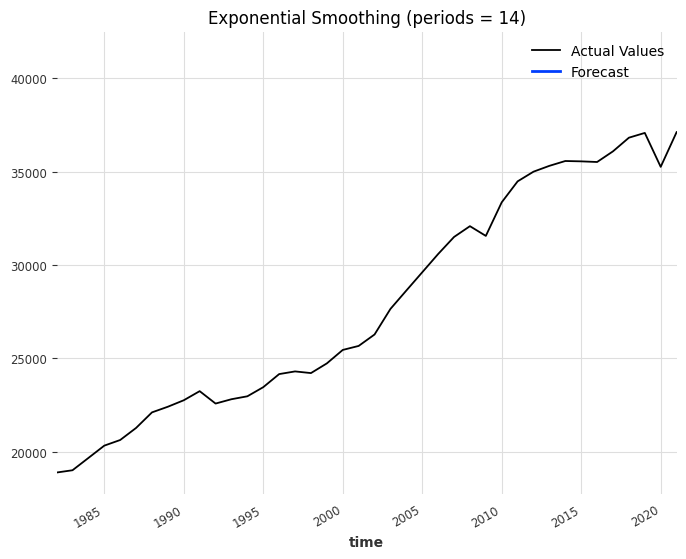

100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


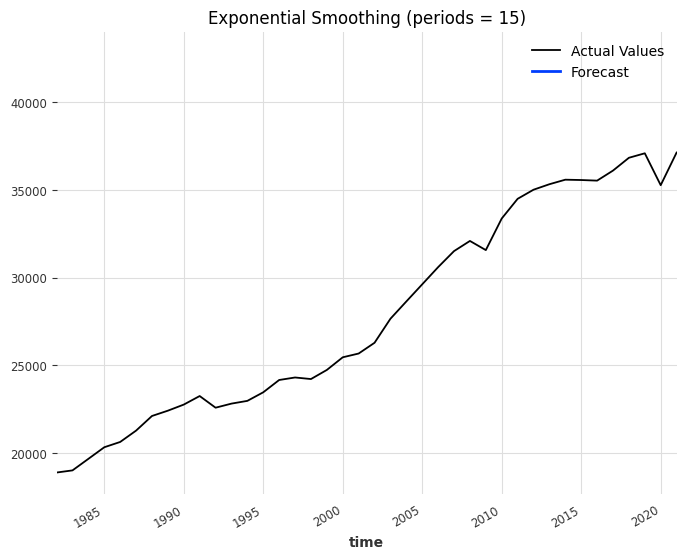

100%|██████████| 11/11 [00:01<00:00,  7.13it/s]


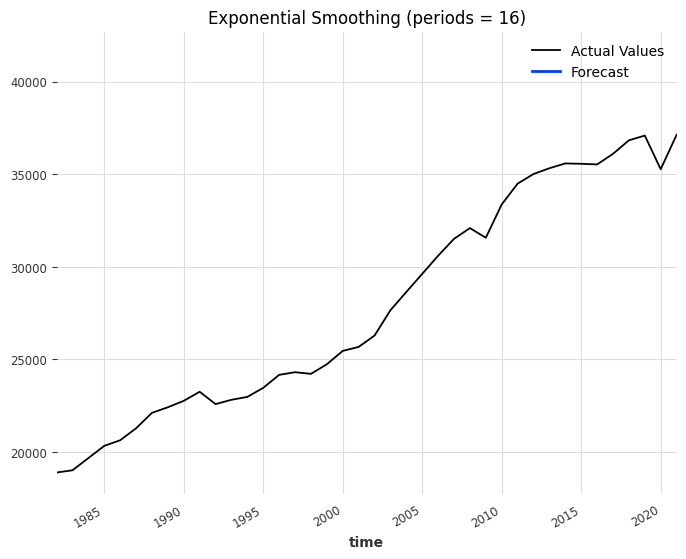

100%|██████████| 11/11 [00:01<00:00,  7.87it/s]


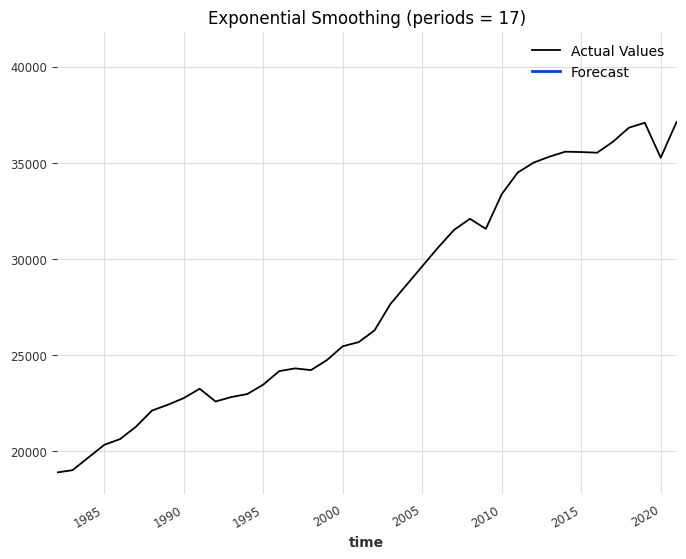

100%|██████████| 11/11 [00:01<00:00,  7.80it/s]


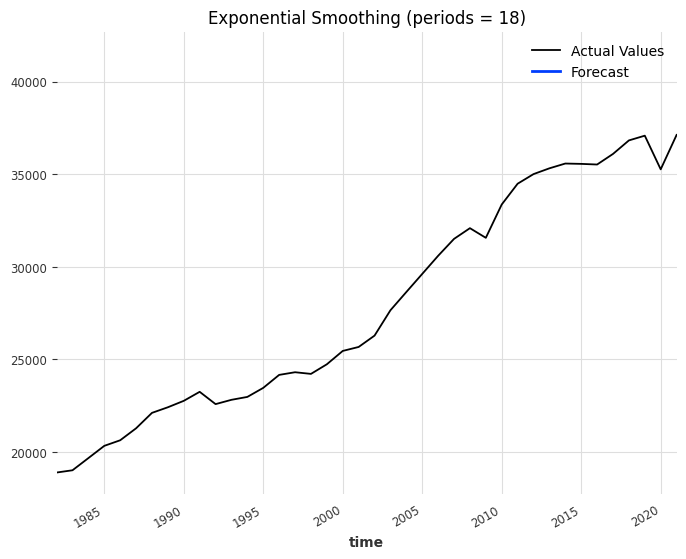

100%|██████████| 11/11 [00:01<00:00,  6.27it/s]


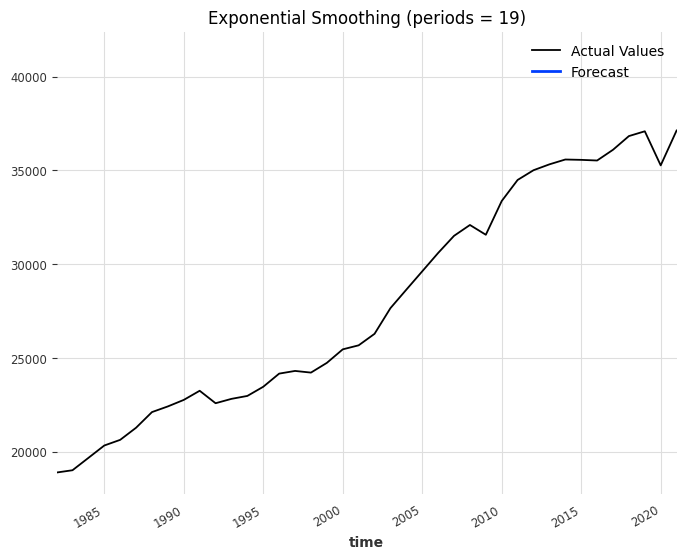

,MAE,RMSE,MAPE,SMAPE,R2
Exponential Smoothing (periods = 2),3613.54,4170.47,10.17,10.46,-24.19
Exponential Smoothing (periods = 3),3640.29,4171.44,10.24,10.54,-24.20
Exponential Smoothing (periods = 4),3715.27,4214.14,10.45,10.73,-24.72
Exponential Smoothing (periods = 5),3676.04,4201.16,10.34,10.62,-24.56
Exponential Smoothing (periods = 6),3686.26,4176.96,10.37,10.66,-24.27
Exponential Smoothing (periods = 7),3680.03,4227.55,10.35,10.63,-24.88
Exponential Smoothing (periods = 8),3762.89,4270.76,10.57,10.84,-25.42
Exponential Smoothing (periods = 9),3647.64,4236.96,10.26,10.52,-25.00
Exponential Smoothing (periods = 10),3840.05,4303.85,10.80,11.06,-25.83
Exponential Smoothing (periods = 11),3883.03,4328.86,10.93,11.24,-26.14


In [ ]:
exp_smoothening_forecasting_series = pd.DataFrame()

for k in range(2, 20):

  model = ExponentialSmoothing(seasonal_periods = k)
  model_name = f'Exponential Smoothing (periods = {k})'
  model.fit(series)

  plt.figure(figsize = (8, 5))

  forecast = model.historical_forecasts(series, start=start, forecast_horizon=12, verbose=True)
  plot_backtest(df['co2'], forecast, model_name)
  df_exp = print_metrics(series, forecast, model_name)
  exp_smoothening_forecasting_series = pd.concat([exp_smoothening_forecasting_series, df_exp])

plt.show()
exp_smoothening_forecasting_series

**Train & Test set Method**

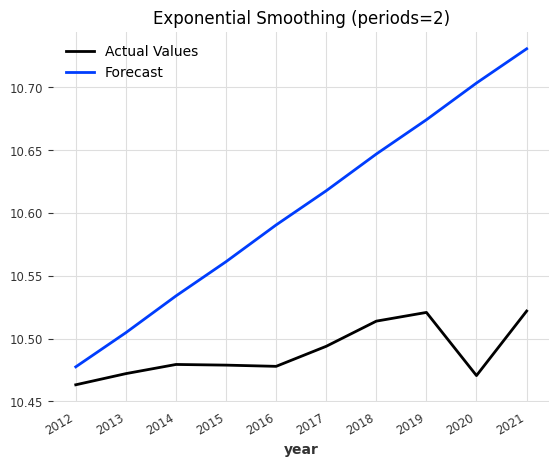

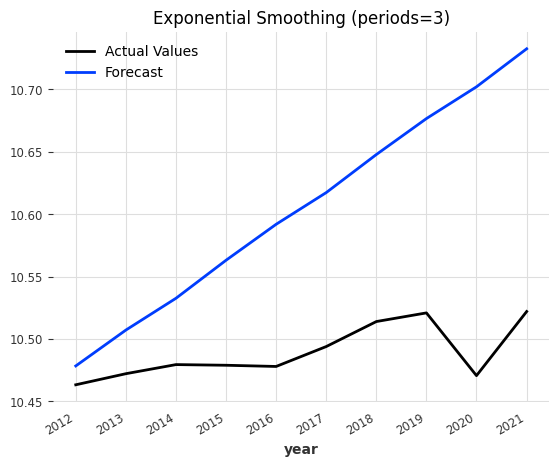

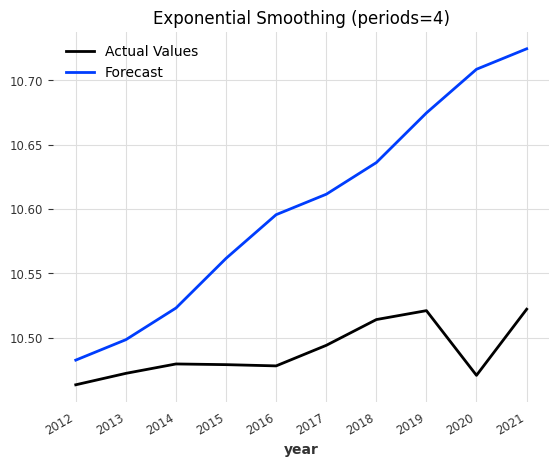

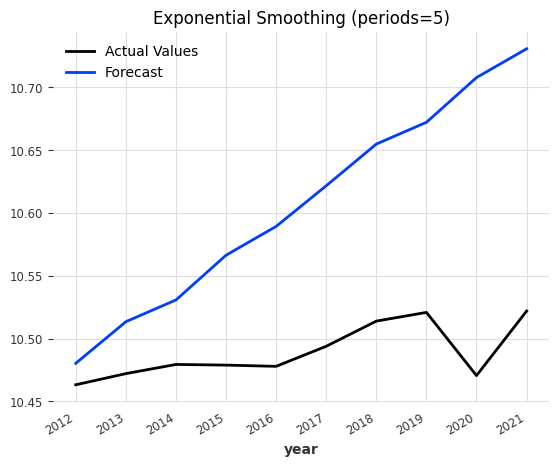

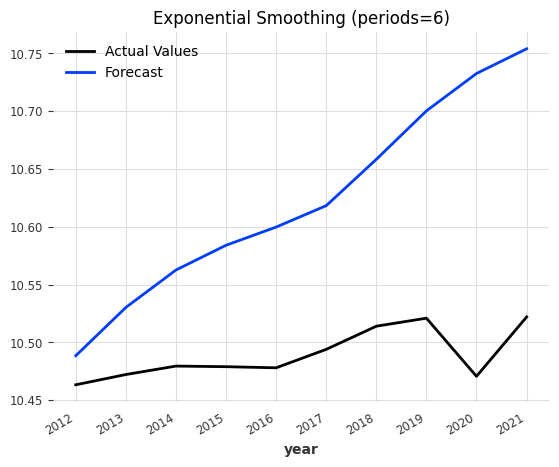

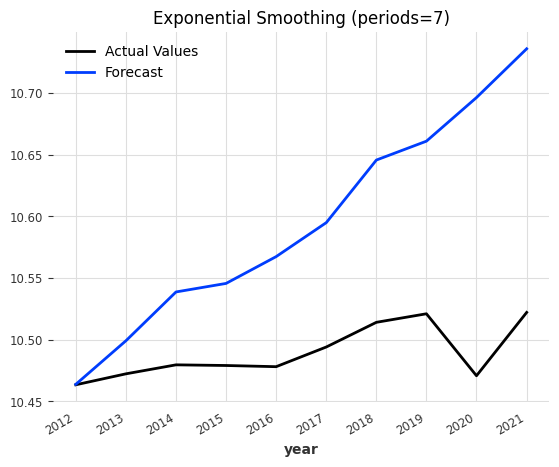

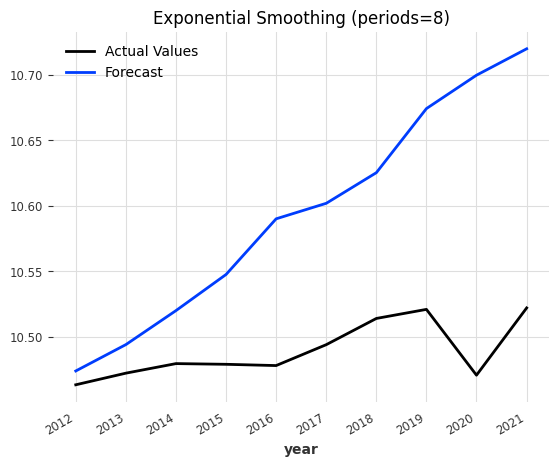

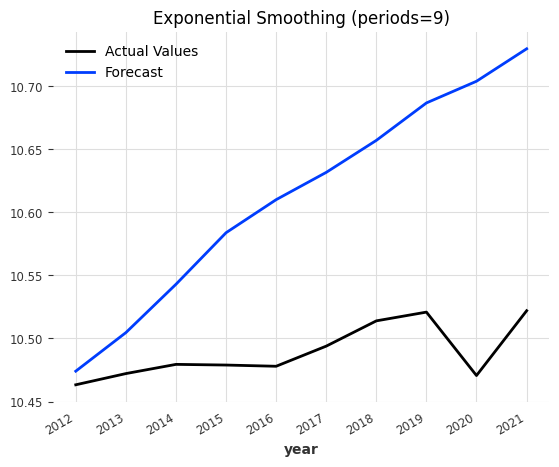

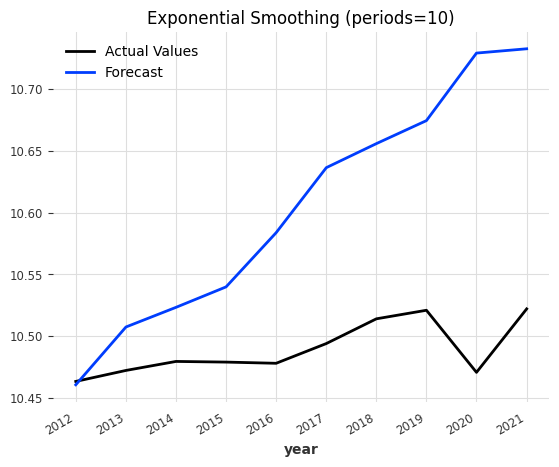

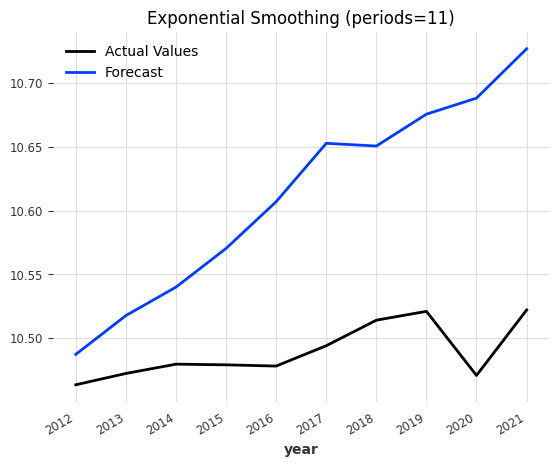

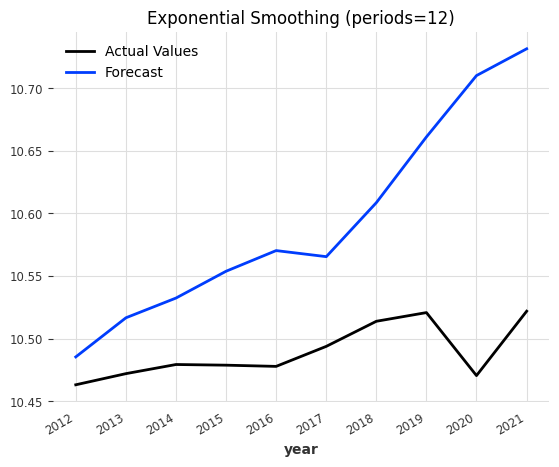

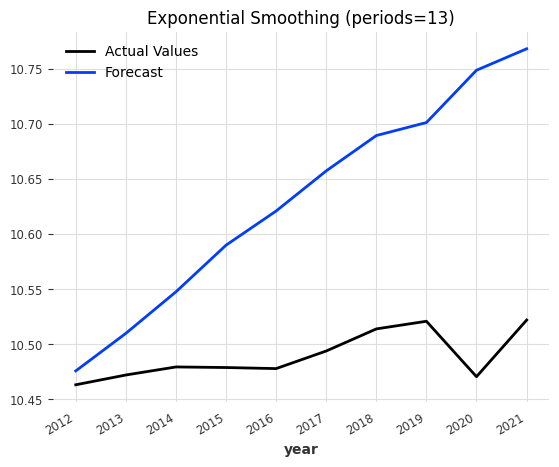

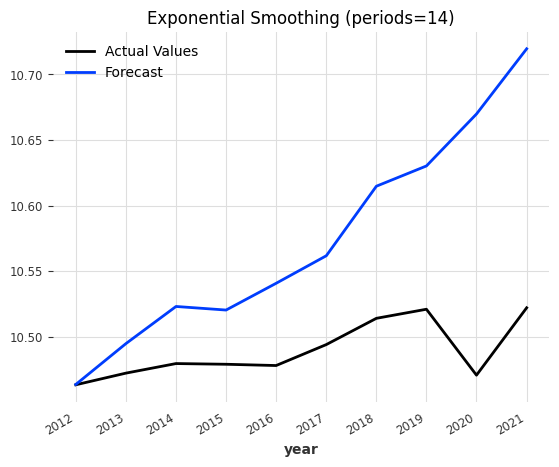

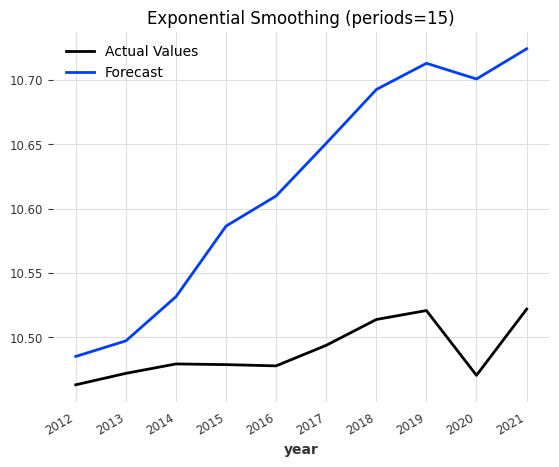

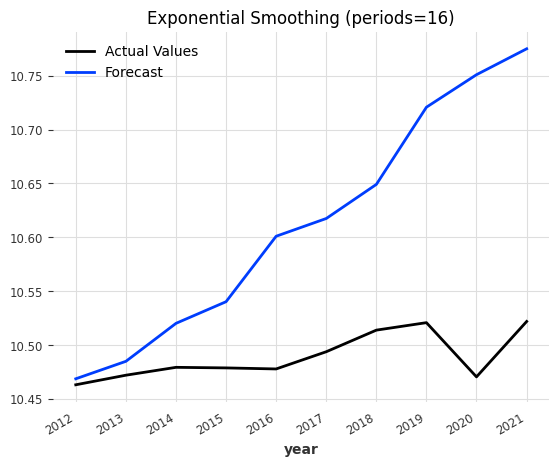

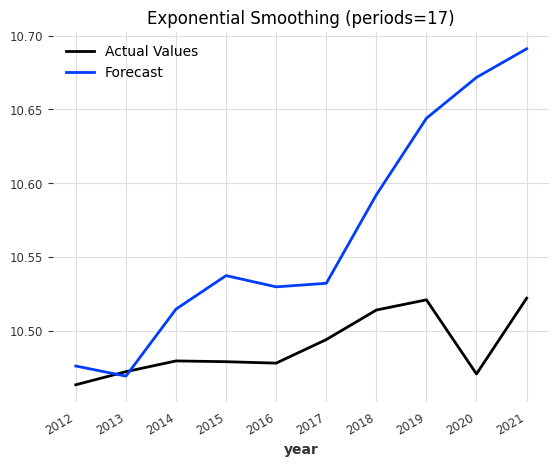

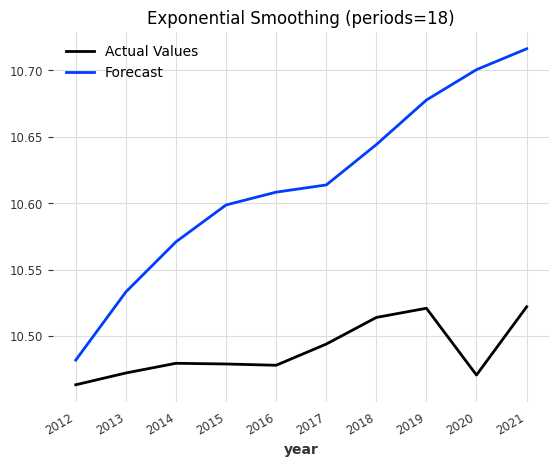

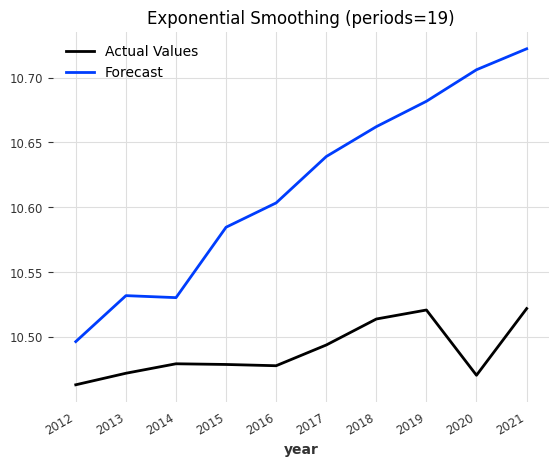

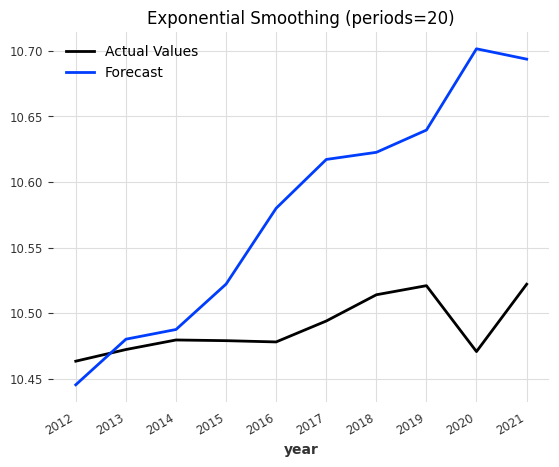

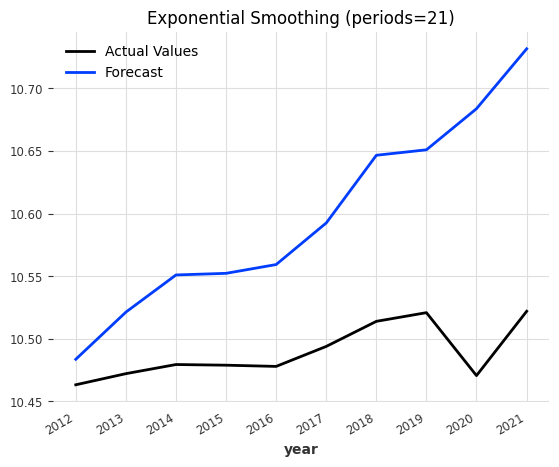

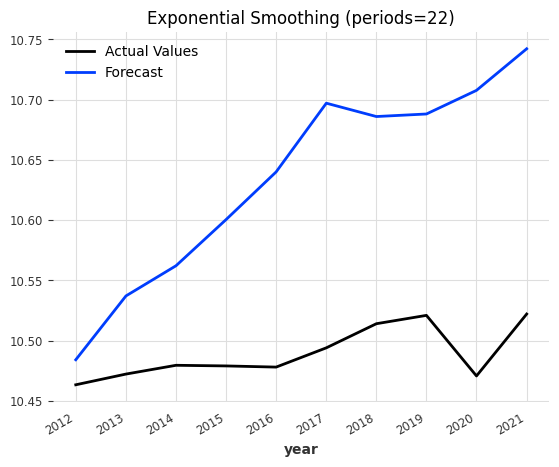

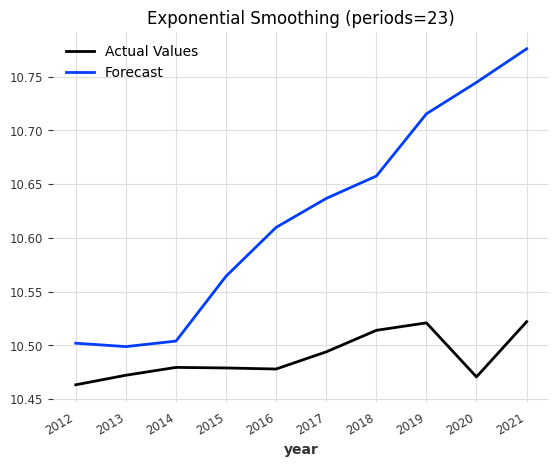

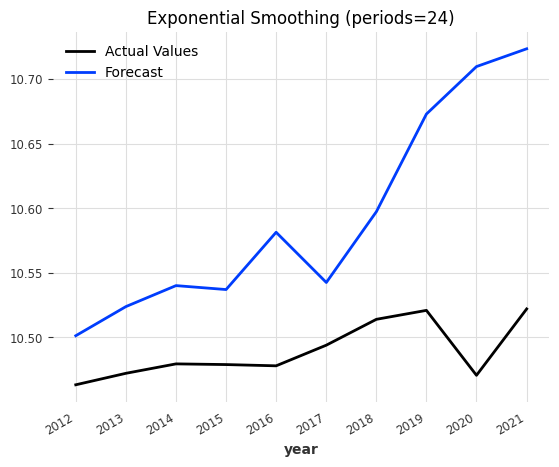

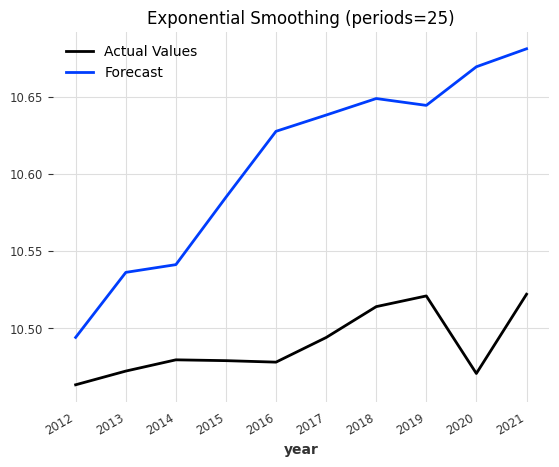

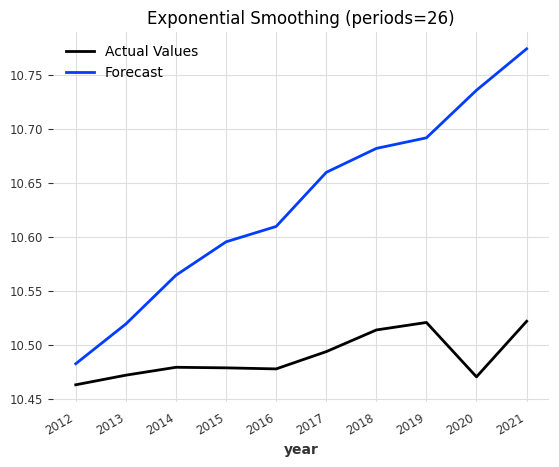

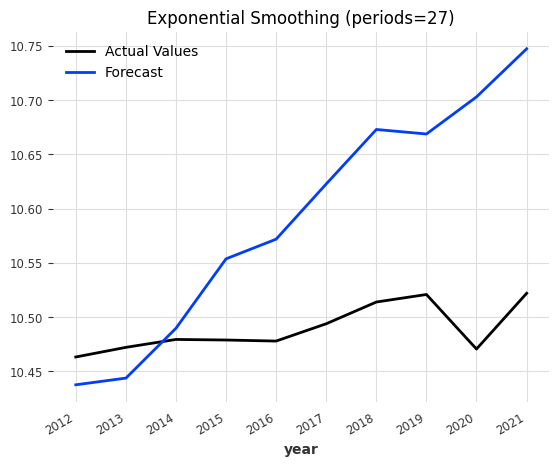

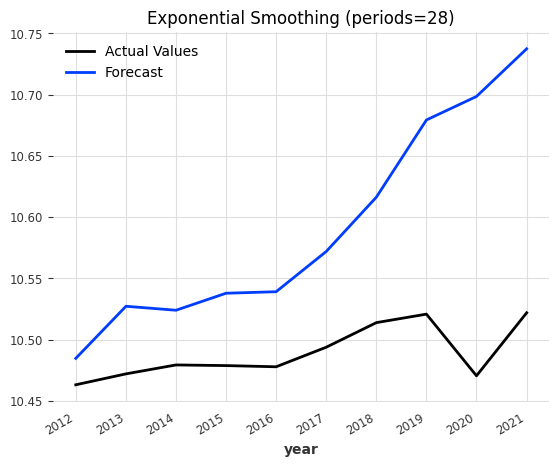

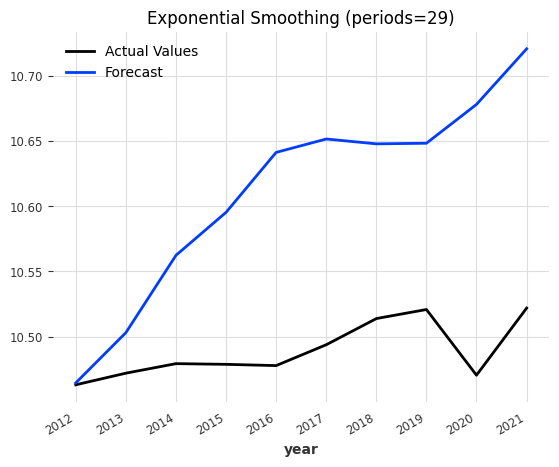

,MAE,RMSE,MAPE,SMAPE,R2
Exponential Smoothing (periods=2),0.11,0.13,1.09,1.09,-39.95
Exponential Smoothing (periods=3),0.12,0.13,1.10,1.09,-40.30
Exponential Smoothing (periods=4),0.11,0.13,1.07,1.06,-38.85
Exponential Smoothing (periods=5),0.12,0.14,1.12,1.11,-41.19
Exponential Smoothing (periods=6),0.13,0.15,1.27,1.26,-51.32
Exponential Smoothing (periods=7),0.11,0.13,1.00,1.00,-35.88
Exponential Smoothing (periods=8),0.11,0.13,1.00,1.00,-35.51
Exponential Smoothing (periods=9),0.12,0.14,1.17,1.16,-44.55
Exponential Smoothing (periods=10),0.12,0.14,1.10,1.09,-43.41
Exponential Smoothing (periods=11),0.12,0.14,1.16,1.16,-42.29


In [82]:
exp_smoothening_forecast = pd.DataFrame()

for k in range(2, 30):

  model = ExponentialSmoothing(seasonal_periods = k)
  model_name = f'Exponential Smoothing (periods={k})'

  model.fit(co2_train)
  forecast = model.predict(len(co2_test))

  plot_backtest(co2_test, forecast, model_name)
  df_exp = print_metrics(co2_test, forecast, model_name)
  exp_smoothening_forecast = pd.concat([exp_smoothening_forecast, df_exp])

exp_smoothening_forecast
#print(forecast.pd_dataframe()).   !!   niet vergeten de gekregen values te vergelijken met echte values  !!

# DeepTCN Model with Optuna Optimization

In [26]:
co2_train = co2_train.astype('float32')
co2_test = co2_test.astype('float32')

In [29]:
def objective(trial):
    # set hyperparameter search space
    input_chunk_length = trial.suggest_int("input_chunk_length", 5, 50)
    output_chunk_length = trial.suggest_int("output_chunk_length", 1, 10)
    n_epochs = trial.suggest_int("n_epochs", 50, 200)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    num_filters = trial.suggest_int("num_filters", 5, 20)
    dilation_base = trial.suggest_int("dilation_base", 2, 5)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])

    # create the TCN model with the hyperparameters
    model = TCNModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        n_epochs=n_epochs,
        kernel_size=kernel_size,
        num_filters=num_filters,
        dilation_base=dilation_base,
        dropout=dropout,
        random_state=28,
    )

    # fit the model on the training data
    model.fit(co2_train, verbose=1)

    # make predictions on the validation set
    forecast = model.predict(len(co2_test))

    # calculate and return the objective value (e.g., mean squared error)
    objective_values = print_metrics(co2_test, forecast, 'TCNModel')
    return objective_values

In [30]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

NotImplementedError: The operator 'aten::roll' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'  Average Metric Score: {trial.value:.4f}')
print('  Hyperparameters:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

# Visualizing results
plot_optimization_history(study)

Best trial:


ValueError: ignored

In [92]:
co2_train = co2_train.astype(np.float32)

In [98]:
PYTORCH_ENABLE_MPS_FALLBACK=1

deeptcn = TCNModel(
    input_chunk_length=20,
    output_chunk_length=2,
    n_epochs=100,
    kernel_size=3,
    num_filters=2,
    dilation_base=2,
    dropout=0.2,
    weight_norm=True,
    random_state=28,
    #likelihood=GaussianLikelihood(),
)

deeptcn.fit(co2_train, verbose=True)

Training: 0it [00:00, ?it/s]

NotImplementedError: The operator 'aten::_weight_norm_interface' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='year'>

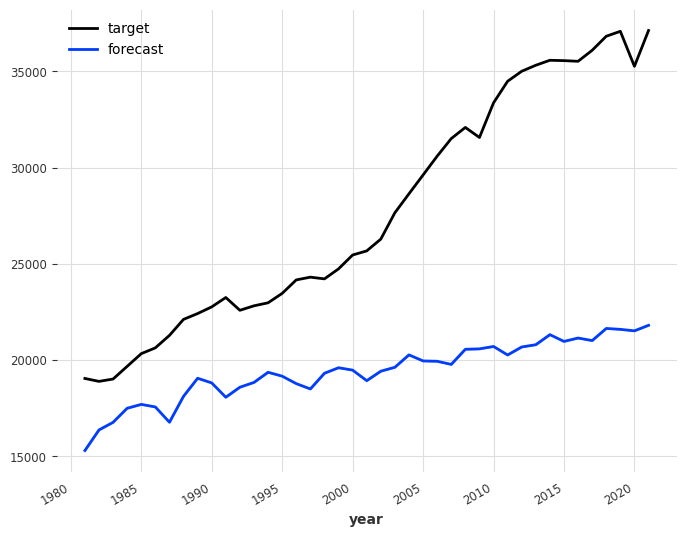

In [ ]:
forecast_horizon = len(val)

pred = deeptcn.predict(forecast_horizon, num_samples=100) # Testen om for_hor te vervangen door gwn val set te vervangen want nu getraind op train set mr val set is de lengte van val set, is dit val set zelf, of zit mee in train ?  ?

val.plot(label="target")
pred.plot(label="forecast")

In [ ]:
print_metrics(val, pred, 'DeepTCNModel')

,MAE,RMSE,MAPE,SMAPE,R2
DeepTCNModel,8268.47,9500.5,27.61,32.91,-1.45


In [ ]:
'''model_name = 'TCN'

plt.figure(figsize = (8, 5))

scaler = Scaler()
scaled_series = scaler.fit_transform(series)
forecast = deeptcn.historical_forecasts(scaled_series,
                                      forecast_horizon=forecast_horizon, verbose=True)
plot_backtest(series, scaler.inverse_transform(forecast), model_name)

df_dl = print_metrics(series, scaler.inverse_transform(forecast), model_name)
df_metrics = df_metrics.append(df_dl)

plt.show()
df_dl'''

# Temporal Fusion Transformers Model (Probabilistic & Deterministic)

https://unit8co.github.io/darts/examples/13-TFT-examples.html

In [ ]:
num_samples = 272

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [ ]:
quantiles = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

In [ ]:
covariates = datetime_attribute_timeseries(series.time_index, attribute="year", one_hot=False)
#covariates = covariates.stack(
    #datetime_attribute_timeseries(series.time_index.year, attribute='month', one_hot=False)
#)

#covariates = covariates.stack(
    #TimeSeries.from_times_and_values(
        #times = series.time_index,
        #values=np.arange(len(series)),
        #columns=['linear_increase'],
    #)
#)

#covariates = TimeSeries.from_times_and_values(
    #times=df.index,
    #values=df.index,
    #columns=["year_covariate"],
#)

covariates = covariates.astype('float32')

In [ ]:
covariates.columns

Index(['year'], dtype='object', name='component')

In [ ]:
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(pd.Timestamp("1980-01-01"))
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

**Creating our model**

To produce deterministic rather than probabilistic forecasts, set parameter likelihood to None and loss_fn to a PyTorch loss function at model creation.

In [ ]:
input_chunk_length = 10
forecast_horizon = 1
TFTModel = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=2,
    num_attention_heads=4,
    dropout=0.2,
    batch_size=32,
    n_epochs=100,
    add_relative_index=False,
    add_encoders=None,
    #likelihood=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),
    #loss_fn=torch.nn.MSELoss(),
    random_state=42,
)

In [ ]:
print(train_transformed.dtype)
print(covariates_transformed.dtype)

float32
float32


In [ ]:
TFTModel.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: 0it [00:00, ?it/s]

TFTModel(hidden_size=64, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x79ca261061d0>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=10, output_chunk_length=1, batch_size=32, n_epochs=100, add_encoders=None, random_state=42)

In [ ]:
forecast  = TFTModel.predict(n=len(val_transformed), num_samples=100)

Predicting: 0it [00:00, ?it/s]

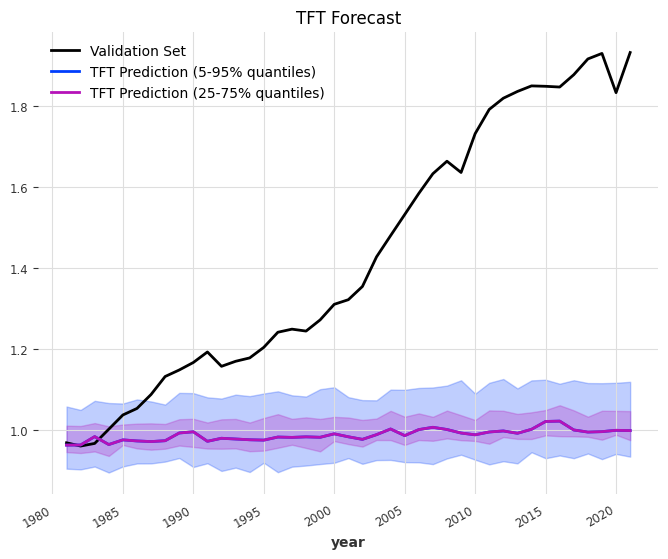

In [ ]:
val_transformed.plot(label='Validation Set')
forecast.plot(low_quantile=0.05, high_quantile=0.95, label='TFT Prediction (5-95% quantiles)')
forecast.plot(low_quantile=0.25, high_quantile=0.75, label='TFT Prediction (25-75% quantiles)')

plt.title('TFT Forecast')
plt.legend()
plt.show()

In [ ]:
ah = print_metrics(val_transformed, forecast, model_name='eee')
ah

,MAE,RMSE,MAPE,SMAPE,R2
eee,0.44,0.54,27.48,33.71,-1.79


**Printing the error metrics**

In [ ]:
#df_TFT = print_metrics(val_series, pred_series["prediction"], model_name="TFT Model")
#df_metrics = pd.concat([df_metrics, df_TFT])

**Looking at the predictions on the validation set**

In [ ]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=len(val_transformed), num_samples=100)

    val_series.plot(label="Actual")


    pred_series.plot(
        low_quantile=0.05, high_quantile=0.95, label="TFT Prediction (5-95% quantiles)"
)
    pred_series.plot(low_quantile=0.25, high_quantile=0.75, label="TFT Prediction (25-75% quantiles)")

    plt.title("TFT Model Forecast")
    plt.legend()

    plt.show()

    df_TFT = print_metrics(val_series, pred_series, model_name="TFT Model")
    pd.concat([df_metrics, df_TFT])
    print(df_TFT)

Predicting: 0it [00:00, ?it/s]

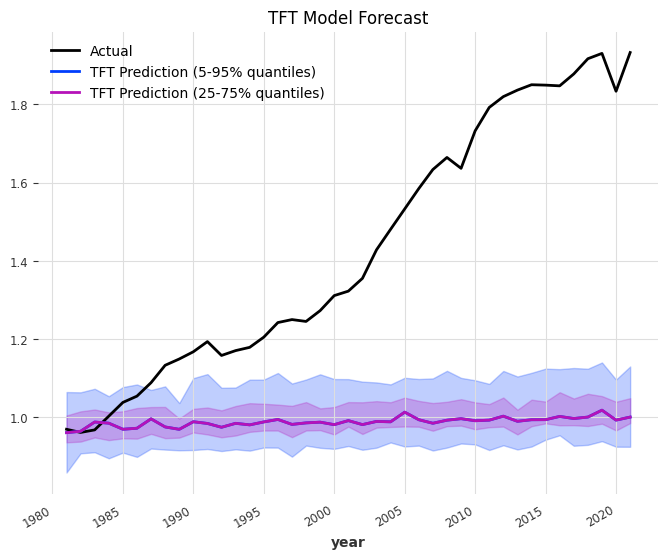

            MAE  RMSE   MAPE  SMAPE    R2
TFT Model  0.44  0.54  27.49  33.77 -1.81


In [ ]:
eval_model(TFTModel, 12, series_transformed, val_transformed)

**Choosing which features to plot**

In [ ]:
def eval_model(model, n, actual_series, val_series, features_to_plot=None):
    pred_series = model.predict(n=len(val_transformed), num_samples=100)

    actual_series.plot(label="Actual")

    if features_to_plot is not None:
        for feature in features_to_plot:
            pred_series[feature].plot(
                low_quantile=0.05, high_quantile=0.95,
                label=f"TFT Prediction - {feature} (5-95% quantiles)"
            )
            pred_series[feature].plot(
                low_quantile=0.25, high_quantile=0.75,
                label=f"TFT Prediction - {feature} (25-75% quantiles)"
            )
    else:
        # Plot all features if features_to_plot is not specified
        for feature in pred_series.columns:
            pred_series[feature].plot(
                low_quantile=0.05, high_quantile=0.95,
                label=f"TFT Prediction - {feature} (5-95% quantiles)"
            )
            pred_series[feature].plot(
                low_quantile=0.25, high_quantile=0.75,
                label=f"TFT Prediction - {feature} (25-75% quantiles)"
            )

    plt.title("TFT Model Forecast")
    plt.legend()

    plt.show()

    df_TFT = print_metrics(val_series, pred_series, model_name="TFT Model")
    pd.concat([df_metrics, df_TFT])
    print(df_TFT)


**Plotting the features after scaling them back**

In [ ]:
def eval_model_not_Scaled(model, n, actual_series, val_series, transformer):
    pred_series = model.predict(n=len(val_series), num_samples=100)

    # Transformeer de voorspellingen terug naar hun oorspronkelijke waarden
    pred_series_backtransformed = transformer.inverse_transform(pred_series)
    val_series_backtransformed = transformer.inverse_transform(val_series)

    # Plot actual series (gevalideerde waarden)
    plt.figure(figsize=(10, 6))
    val_series_backtransformed.plot(label="Actual")

    # Plot prediction with quantile ranges (5-95% quantiles)
    pred_series_backtransformed.plot(
        low_quantile=0.05, high_quantile=0.95, label="TFT Prediction (5-95% quantiles)"
    )

    # Plot prediction with quantile ranges (25-75% quantiles)
    pred_series_backtransformed.plot(
        low_quantile=0.25, high_quantile=0.75, label="TFT Prediction (25-75% quantiles)"
    )

    plt.title("TFT Model Forecast")
    plt.legend()
    plt.show()

    # Bereken en print de metrieken op de oorspronkelijke schaal
    pred_series_prediction = pred_series_backtransformed
    df_TFT = print_metrics(val_series_backtransformed, pred_series_prediction, model_name="TFT Model")
    pd.concat([df_metrics, df_TFT])
    print(df_TFT)


Predicting: 0it [00:00, ?it/s]

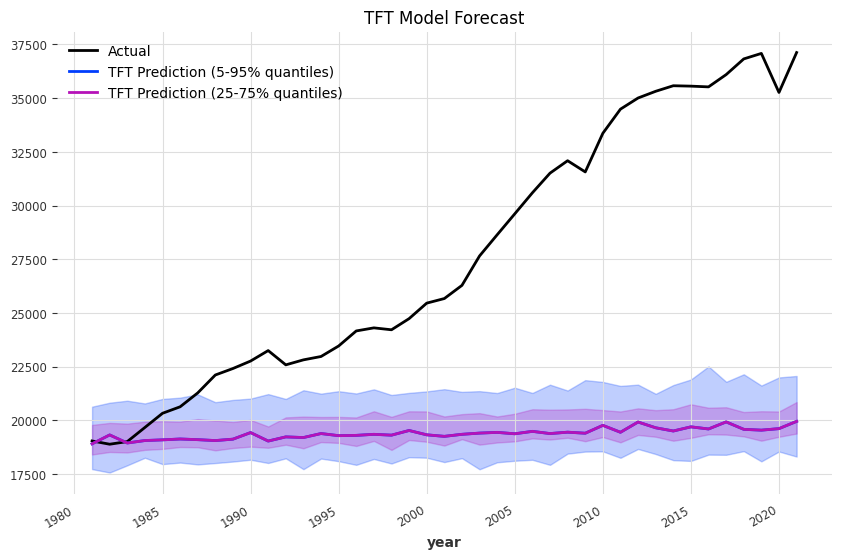

              MAE      RMSE   MAPE  SMAPE   R2
TFT Model  8317.3  10157.85  26.78  32.67 -1.8


In [ ]:
eval_model_not_Scaled(TFTModel, 12, series_transformed, val_transformed, transformer)